In [2]:
import numpy as np
import random
import csv
import math
from collections import OrderedDict
import os

# Part 1: Setting up and Running the Simulation

## Read from txt

In [3]:
groups = 3
grp_col = tuple((i) for i in range(0, groups+1))

# stores the mortality of species by groups
def get_data(filename, grp_col):
    group = {}
    for i in range(1, groups+1):
        group["group %s" % i] = np.genfromtxt(filename, delimiter=',', usecols=grp_col, unpack=True)
        group["group %s" % i] = group["group %s" % i][i]
    return group

group_mort = get_data('data/year-group-mort.csv', grp_col)
group_mort = OrderedDict(sorted(group_mort.items()))
#print("Group Mortalities: %s" % group_mort)

group_recr = get_data('data/year-group-recr.csv', grp_col)
group_recr = OrderedDict(sorted(group_recr.items()))
#print("Group Recruitments: %s" % group_recr)

species_num, mort_grp, recr_grp = np.genfromtxt('data/species-group-michiel.csv', delimiter=',', usecols = (0, 1, 2), unpack=True, dtype=int)
# Stacks the three arrays together to form a matrix
species_mort_recr = np.vstack((species_num, mort_grp, recr_grp)).transpose()
# To make sure that I can put a sublist within a list to store the recruitment and mortalities over years
species_mort_recr = np.array(species_mort_recr, dtype=object)

## Updating mortalities and recruitments for each species

In [4]:
species_num, mort_grp, recr_grp = np.genfromtxt('data/species-group-michiel.csv', delimiter=',', usecols = (0, 1, 2), unpack=True, dtype=int)
# Stacks the three arrays together to form a matrix
species_mort_recr = np.vstack((species_num, mort_grp, recr_grp)).transpose()
# To make sure that I can put a sublist within a list to store the recruitment and mortalities over years
species_mort_recr = np.array(species_mort_recr, dtype=object)

####### Binds the three tables together #######
# print(species_mort_recr.shape)
for s in range(len(species_num)):
    # Get which group that particular species comes from
    mort_group = species_mort_recr[s][1]
    recr_group = species_mort_recr[s][2]
    #print("mortality groups: %s" % mort_group)
    # Getting the mortalities and recruitments from the dictionary we read from file
    mortalities = num_mort[mort_group - 1]
    #print("mortalities %s" % mortalities)
    recruitments = num_recr[recr_group - 1]
    #print("recruitments %s" % recruitments)
    # Update the matrix appropriately
    species_mort_recr[s][1] = mortalities
    species_mort_recr[s][2] = recruitments
# End result: a 500 x 3 matrix of 500 species, their mortality rates over year, and recruitment rates over year

print("Matrix of 500 species, their mortality and recruitment rates over year")
print(species_mort_recr)

Matrix of 500 species, their mortality and recruitment rates over year
[[1
  array([ 10.05403735,  10.13192707,  10.3170281 ,  10.74380165,
        11.68445123,  13.62741231,  17.29728962,  23.46968079,
        32.5       ,  43.83430842,  56.04278481,  67.4906107 ,
        77.05921128,  84.38016529,  89.63385834,  93.24035638,
        95.64343119,  97.21360786,  98.22664445,  98.87493595,
        99.2876637 ,  99.54955834,  99.715396  ,  99.82026964,
        99.88653508,  99.92838348,  99.95480307,  99.9714787 ,
        99.9820027 ,  99.98864384,  99.9928345 ,  99.99547877,
        99.99714726,  99.99820003,  99.99886429,  99.99928341,
        99.99954786,  99.99971472,  99.99982   ,  99.99988643,
        99.99992834,  99.99995479,  99.99997147,  99.999982  ,
        99.99998864,  99.99999283,  99.99999548,  99.99999715,
        99.9999982 ,  99.99999886,  99.99999928,  99.99999955,
        99.99999971,  99.99999982,  99.99999989,  99.99999993,
        99.99999995,  99.99999997,  99.99

In [13]:
species_mort_recr[:, 2].shape

(500,)

In [4]:
age, recr, mort, density = np.genfromtxt('data/mortality-recruitment.csv', delimiter=',', usecols=(1,2, 3,4), unpack=True, dtype=int)
age = age[1:]
recr_by_year = recr[1:]
mort_by_year = mort[1:]
density = density[1:]

## Parameters (to be changed)

In [5]:
## TODO: Take into account the user_input -> table
global plots, years, species_global_pool, local_pool_size, temporary_pool_size
plots = 50
years = len(age)
species_global_pool = 1000 #len(species_num)
local_pool_size = 200
temporary_pool_size = 250 # Beta diversity measure of local species pool

s = np.arange(0, species_global_pool, 1)
#p = np.arange(0, species_global_pool, 1)
p = [3] * species_global_pool
global_pool = (s, p)

# number tells you the number of recruits / deaths for each year
# TODO: Read from file later - DONE
recruit_rate = recr_by_year
species_recruit_rate = np.ones((species_global_pool, years))
print(species_recruit_rate.shape)
death_rate = mort_by_year

(1000, 35)


## Initialization

In [6]:
def create_species_matrix(plots, years, species):
    # initializes the matrix for the number of plots and years
    # for output 
    species_matrix = np.zeros((plots, years, species))
    return species_matrix

def sampling_func(species_list, required_num, replacement):
    """
    Species List: A tuple containing (list of species, abundances)
    Required num: The number of species you want to draw
    Replacement: A boolean, whether you want to draw with replacement or without
    """
    list_of_species = species_list[0]
    abundances = species_list[1]
    probabilities = []
    total_abundance = np.sum(abundances)
    total_abundance = total_abundance.astype(float)
    
    for i in range(len(abundances)):
        p = abundances[i] / total_abundance
        probabilities.append(p)
#     print("abundances %s" % abundances)  
#     print("total abundance %s" % total_abundance)     
#     print(probabilities)
        
    result = np.random.choice(list_of_species, required_num, replace=replacement, p=probabilities)

    return result

## Determining beta diversity in local species pool

In [7]:
def create_temporary_pool(size_of_temp_pool, global_pool):
    """
    Returns the temporary pool, where each element is the species type
    """
    # s: list of species in the global pool
    temp_pool = sampling_func(global_pool, size_of_temp_pool, False)
    abundances = np.take(global_pool[1], temp_pool)
    return (temp_pool, abundances)

## Creating Local Species Pool for Plots

In [8]:
def create_local_species_pool(plots,  local_pool_size, temp_pool):
        local_species_pools = sampling_func(temp_pool, local_pool_size, False)
#         abundances = np.take(global_pool[1], local_species_pool)
#         print(abundances)
        return local_species_pools

## Simulation

In [9]:
def plot_year_species(plots, years):
    species_matrix = create_species_matrix(plots, years, species_global_pool)
    for p in range(plots):
        # Local species pool for 1 plot
        temp_pool = create_temporary_pool(temporary_pool_size, global_pool)
        local_pool = create_local_species_pool(plots, local_pool_size, temp_pool)
        current_species_abundance = np.zeros(species_global_pool)
        
        for y in range(years):
            # Send the trees to a better life 
            if (y != 0):
                deaths = sampling_func((global_pool[0], current_species_abundance), death_rate[y], True)
                for d in deaths:
                    if (current_species_abundance[d] == 0):
                        break
                    else: 
                        current_species_abundance[d] -= 1
                    
            # TODO: Update the abundance in current_species_abundance (DONE)
            # Recruitment rate: Not affected by abundance of species in plot, but by species type and by year
            # recruit_year -> for that particular year, what are the rates of recruitment
            recruit_year = species_recruit_rate[:,y]
            local_recruitment_rate = np.take(recruit_year, local_pool)
            recruits = sampling_func((local_pool, local_recruitment_rate), recruit_rate[y], True)
            for r in recruits:
                current_species_abundance[r] += 1
            
            for s in range(species_global_pool):
                species_matrix[p][y][s] = current_species_abundance[s]
                
    return species_matrix

plot_year_species = plot_year_species(plots, years)
#print(plot_year_species)

# Part 2: Calculating Normal Diversities

## Calculating D0 Diversities

In [10]:
d0_alpha_diversity = np.zeros(years)
d0_beta_diversity = np.zeros(years)
d0_gamma_diversity = np.zeros(years)
# Calculating D0_diversities 
for y in range(years):
    # Calculating alpha diversity
    average_alpha_diversity = 0
    for p in range(plots):
        alpha_diversity = 0
        for s in range(species_global_pool):
            if plot_year_species[p][y][s] > 0:  
                alpha_diversity += 1    
        average_alpha_diversity = average_alpha_diversity + alpha_diversity
    d0_alpha_diversity[y] = average_alpha_diversity / plots
    #print(d0_alpha_diversity)
 
    # Calculating gamma_diversity
    gamma_diversity = 0 
    for s in range(species_global_pool):
        sp_boolean = False
        for p in range(plots):
            if plot_year_species[p][y][s] > 0:
                sp_boolean = True
        if sp_boolean:
            gamma_diversity += 1
    d0_gamma_diversity[y] = gamma_diversity
    
    # Calculating beta diversity
    d0_beta_diversity[y] = d0_gamma_diversity[y] / d0_alpha_diversity[y]
print("d0_alpha_diversity = %s" % d0_alpha_diversity)   
print("d0_gamma_diversity = %s" % d0_gamma_diversity)
print("d0_beta_diversity = %s" % d0_beta_diversity)
# End of Calculating D0 Diversities

d0_alpha_diversity = [ 155.26  188.88  196.04  196.78  197.02  196.74  195.66  195.06  194.42
  193.44  192.1   190.94  189.6   188.46  187.1   186.04  184.26  183.14
  182.52  181.64  180.98  180.82  180.02  179.22  178.52  177.3   176.52
  176.2   175.66  174.76  173.52  173.08  172.02  171.76  171.66]
d0_gamma_diversity = [ 1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.
  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.
  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.
  1000.  1000.  1000.  1000.  1000.]
d0_beta_diversity = [ 6.44080897  5.29436679  5.1009998   5.08181726  5.07562684  5.08285046
  5.11090667  5.1266277   5.14350375  5.16956162  5.20562207  5.2372473
  5.2742616   5.30616576  5.34473544  5.37518813  5.42711386  5.46030359
  5.47885163  5.50539529  5.52547243  5.53036169  5.55493834  5.5797344
  5.60161326  5.64015792  5.66508044  5.6753689   5.69281567  5.72213321
  5.76302444  5.77767506  5.81327753  5.

## Import packages for plotting

In [11]:
from matplotlib import pyplot as plt
%matplotlib inline
graph_typ = "OriginalData"

## Plotting D0 diversities against time

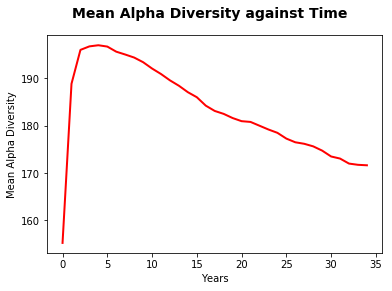

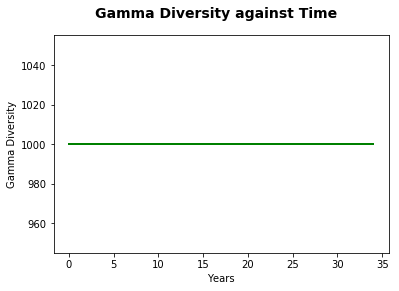

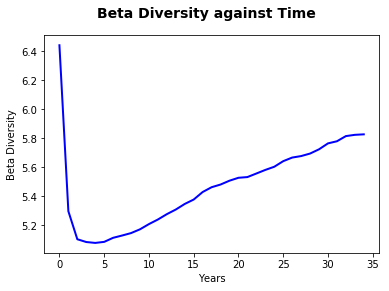

In [12]:
x = [i for i in range(years)]

def plot_d0_diversities(x, y, col, ylab, xlab='Years'):
    div_typ = 'd0'
    fig = plt.figure()
    fig.suptitle('%s against Time' % ylab, fontsize=14, fontweight='bold')
    
    ax = fig.add_subplot(111)
    plt.plot(x, y, color=col, linewidth=2.0)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    fig.savefig('results/%s/%s_%s.jpg' % (graph_typ, div_typ, ylab))
    plt.show

plot_d0_diversities(x, d0_alpha_diversity, 'r', "Mean Alpha Diversity")
plot_d0_diversities(x, d0_gamma_diversity, 'g', "Gamma Diversity")
plot_d0_diversities(x, d0_beta_diversity, 'b', "Beta Diversity")

In [13]:
# Summing over all the plots, for each species over 35 years
across_plots = np.sum(plot_year_species, axis=0).transpose()
print(across_plots.shape)
# Summing over all species, so you get the total number of species across all plots each year
total_species = np.sum(across_plots, axis=0)
print(total_species)

# Calculate Gamma diversity
d1_gamma_diversity = np.zeros(years)
for y in range(years):
    gamma_diversity = 0
    for s in range(species_global_pool):
        p = across_plots[s][y] / total_species[y]
        if (p!=0):
            gamma_diversity +=  -((p) * math.log(p, math.e))
    gamma_diversity = math.exp(gamma_diversity)
    d1_gamma_diversity[y] = gamma_diversity
print("gamma div: %s" % d1_gamma_diversity)

# Calculate Alpha Diversity
d1_alpha_diversity = np.zeros(years)
for y in range(years):
    alpha_diversity_by_plot = []
    for p in range(plots):
        alpha_diversity = 0 
        div_probabilities = []
        # sum over all species
        diversity_abundance = np.sum(plot_year_species[p][y])
        # for each species
        for s in range(len(plot_year_species[p][y])):
            probability_s = (plot_year_species[p][y][s]/diversity_abundance)
            # Calculate alpha diversity per plot, summing across species
            if (probability_s != 0):
                alpha_diversity += -((probability_s) * (math.log(probability_s,math.e)))
        alpha_diversity = math.exp(alpha_diversity)
        alpha_diversity_by_plot.append(alpha_diversity)
        # Get total alpha diversity
        total_alpha_diversity = np.sum(alpha_diversity_by_plot)
        # Get the average
    average_alpha_diversity = total_alpha_diversity / plots
    d1_alpha_diversity[y] = average_alpha_diversity

print("alpha div: %s" % d1_alpha_diversity)
# Calculate Beta Diversity
d1_beta_diversity = np.divide(d1_gamma_diversity, d1_alpha_diversity)
print("beta div: %s" % d1_beta_diversity)

(1000, 35)
[ 14950.  28965.  39227.  43589.  43979.  42704.  40858.  39065.  37103.
  35382.  33814.  32438.  31145.  30039.  29062.  28172.  27354.  26702.
  26008.  25354.  24771.  24193.  23774.  23381.  22999.  22597.  22207.
  21821.  21523.  21192.  20994.  20717.  20474.  20252.  20030.]
gamma div: [ 929.25163246  945.66442462  949.20362752  949.80858946  950.77168329
  949.67290605  949.07353841  948.97146499  948.95032102  949.29935652
  948.1313684   947.59026719  947.4092909   946.42835131  946.20592894
  945.29274755  945.86821595  944.21036186  944.71034522  944.02114245
  943.31340371  943.7714346   942.9642722   941.26831587  941.35280518
  940.13411323  939.1843345   939.02376818  939.48779439  937.77468914
  936.33491306  936.36656432  935.64620927  935.80888237  935.75221104]
alpha div: [ 135.89300822  165.43217501  174.37449319  176.34640085  176.78335286
  176.00155405  174.34560103  173.11320009  171.90642386  170.60940445
  168.91050385  167.6500431   166.20392919

## Plotting D1 diversities against time

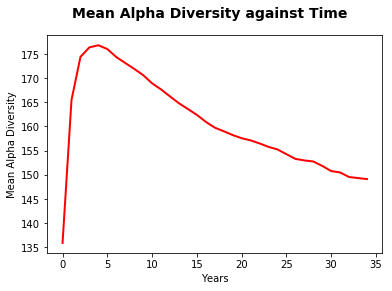

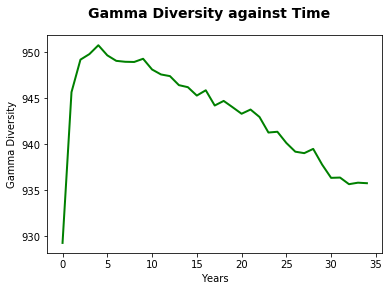

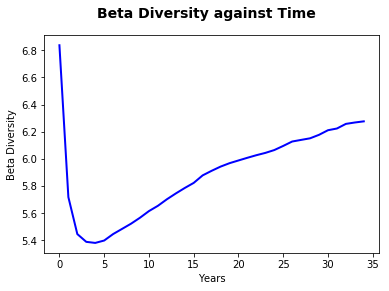

In [14]:
x = [i for i in range(years)]

def plot_d1_diversities(x, y, col, ylab, xlab='Years'):
    div_typ="d1"
    fig = plt.figure()
    fig.suptitle('%s against Time' % ylab, fontsize=14, fontweight='bold')
    
    ax = fig.add_subplot(111)
    plt.plot(x, y, color=col, linewidth=2.0)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    fig.savefig('results/%s/%s_%s.jpg' % (graph_typ, div_typ, ylab))
    plt.show

plot_d1_diversities(x, d1_alpha_diversity, 'r', "Mean Alpha Diversity")
plot_d1_diversities(x, d1_gamma_diversity, 'g', "Gamma Diversity")
plot_d1_diversities(x, d1_beta_diversity, 'b', "Beta Diversity")

## Calculating D2 Diversities

In [15]:
# Summing over all the plots, for each species over 35 years
# across_plots = np.sum(plot_year_species, axis=0).transpose()
# print(across_plots.shape)
# # Summing over all species, so you get the total number of species across all plots each year
# total_species = np.sum(across_plots, axis=0)
# print(total_species)

# Calculate Gamma diversity
d2_gamma_diversity = np.zeros(years)
for y in range(years):
    div_probabilities = []
    species_across_plots = []
    # for each species
    for s in range(species_global_pool):
        total = 0
        # summing across the landscapes
        for p in range(plots):
            total += plot_year_species[p][y][s]
        species_across_plots.append(total)
    overall_abundance = np.sum(species_across_plots)
    
    p=0
    for i in range(len(species_across_plots)):
        p += (species_across_plots[i] / overall_abundance) ** 2.0
    d2_gamma_diversity[y] = 1/p
print("gamma div: %s" % d2_gamma_diversity)
    
# Calculate Alpha Diversity
d2_alpha_diversity = np.zeros(years)
for y in range(years):
    alpha_diversity_by_plot = []
    for p in range(plots):
        alpha_diversity = 0 
        div_probabilities = []
        # sum over all species
        diversity_abundance = np.sum(plot_year_species[p][y])
        # for each species
        for s in range(len(plot_year_species[p][y])):
            probability_s = (plot_year_species[p][y][s]/diversity_abundance)
            # Calculate alpha diversity per plot, summing across species
            if (probability_s != 0):
                alpha_diversity += probability_s ** 2
        alpha_diversity_by_plot.append(1 / alpha_diversity)
        # Get total alpha diversity
        total_alpha_diversity = np.sum(alpha_diversity_by_plot)
        # Get the average
    average_alpha_diversity = total_alpha_diversity / plots
    d2_alpha_diversity[y] = average_alpha_diversity
print("alpha div: %s" % d2_alpha_diversity)
# Calculate Beta Diversity
d2_beta_diversity = np.divide(d2_gamma_diversity, d2_alpha_diversity)
print("beta div: %s" % d2_beta_diversity)

gamma div: [ 874.48450986  900.84001649  906.72759355  908.22006687  909.57429776
  907.47083763  906.4154563   906.5444604   906.95086928  907.33597538
  905.27701453  904.48989198  904.257911    902.35866581  901.62780251
  899.81245989  901.59332458  898.87747476  899.46074061  897.86592881
  896.57494101  897.61732261  896.17190805  893.43893422  892.86238933
  890.87310289  889.11598603  889.15537567  889.98093966  887.07076405
  884.85853443  885.06948262  883.92694684  884.13575574  884.06851295]
alpha div: [ 120.0487992   148.76375668  159.15419438  161.82643745  162.44554077
  161.32470212  159.34291379  157.68119412  156.1311332   154.72946186
  152.78616961  151.29405061  149.69201663  148.04048298  146.88209622
  145.51948419  144.27898019  143.03708234  142.14583361  141.43211529
  140.66046663  139.90791995  139.39845431  138.69216789  138.22958464
  137.31291673  136.22614625  135.73759272  135.66650196  134.7115472
  133.81415387  133.54704574  132.69069085  132.4133471

## Plotting D2 Diversities against Time

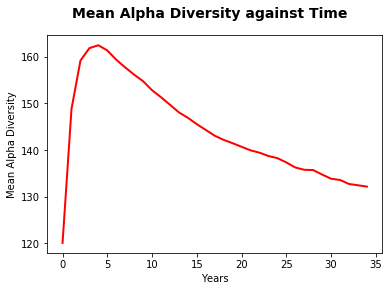

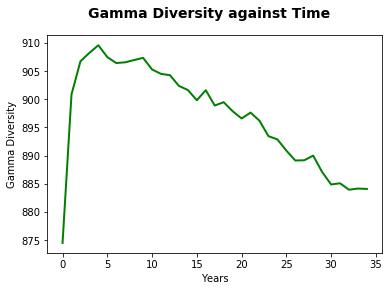

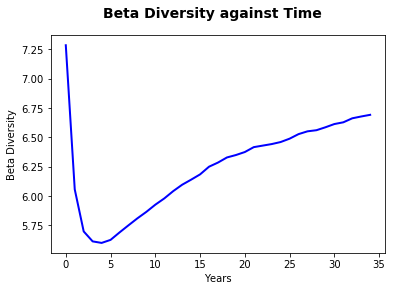

In [16]:
x = [i for i in range(years)]

def plot_d2_diversities(x, y, col, ylab, xlab='Years'):
    div_typ="d2"
    fig = plt.figure()
    fig.suptitle('%s against Time' % ylab, fontsize=14, fontweight='bold')
    
    ax = fig.add_subplot(111)
    plt.plot(x, y, color=col, linewidth=2.0)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    fig.savefig('results/%s/%s_%s.jpg' % (graph_typ, div_typ, ylab))
    plt.show

plot_d2_diversities(x, d2_alpha_diversity, 'r', "Mean Alpha Diversity")
plot_d2_diversities(x, d2_gamma_diversity, 'g', "Gamma Diversity")
plot_d2_diversities(x, d2_beta_diversity, 'b', "Beta Diversity")

## Overall density curve

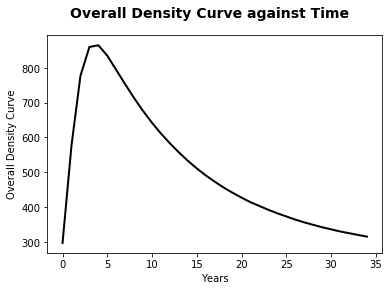

In [17]:
def plot_density_curve(x, y, col, ylab, xlab='Years'):
    fig = plt.figure() 
    fig.suptitle('%s against Time' % ylab, fontsize=14, fontweight='bold')
    
    ax = fig.add_subplot(111)
    plt.plot(x, y, color=col, linewidth=2.0)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    fig.savefig('results/%s/%s.jpg' % (graph_typ, ylab))
    plt.show
    
plot_density_curve(x, density, 'black', "Overall Density Curve")

# Part 3: Calculating Pairwise Diversities

In [18]:
from itertools import combinations
import time

In [19]:
print(plot_year_species.shape)
new_matrix = np.rollaxis(plot_year_species, axis=1)
print(new_matrix.shape)

# get plot combinations
plot_arr = [i for i in range(plots)]
plot_comb = list(combinations(plot_arr, 2))
# print(plot_comb)

(50, 35, 1000)
(35, 50, 1000)


## Calculate Turnover, Sorensen and Jaccard Dissimilarities for beta - Marion et. al. 

In [20]:
def calculate_turnover(beta):
    t = np.subtract(beta, 1)
    return t

def calculate_sorensen(beta, q):
    if (q==0):
        s = np.subtract(beta, 1)
        return s 
    elif(q==1):
        s = np.divide(np.log(beta), math.log(2))
        return s 
    else:
        s = np.subtract(2, np.divide(2, beta))
        return s

def calculate_jaccard(beta, q):
    if (q==0):
        j = np.subtract(2, np.divide(2, beta))
        return j
    elif (q==1):
        j = np.divide(np.log(beta), math.log(2))
        return j
    else:
        j = np.subtract(beta, 1)
        return j

## For D0

In [42]:
start = time.time()
itera = 0
d0_beta_turnover = []
d0_beta_sorensen = []
d0_beta_jaccard = []
for comb in plot_comb:
    start_time = time.time()
    # separate the pairings
    p1 = comb[0]
    p2 = comb[1]
    d0_gamma_diversity = []
    d0_alpha_diversity = []
    for y in range(years):
        # create the plot_species_matrix to calculate diversities
        p1_spec = plot_year_species[p1][y]
        p2_spec = plot_year_species[p2][y]
        plot_species_matrix = np.vstack((p1_spec, p2_spec)).transpose()
        
        # calculate gamma diversity
        sum_across_plots = np.sum(plot_species_matrix, axis=1) # gets the sum of each species across plots
        d0_gamma = np.count_nonzero(sum_across_plots)
        d0_gamma_diversity.append(d0_gamma)
        
        # calculate alpha diversity
        d0_alpha = np.zeros(2)
        d0_alpha[0] = np.count_nonzero(p1_spec)
        d0_alpha[1] = np.count_nonzero(p2_spec)

        d0_alpha_mean = np.mean(d0_alpha)
        d0_alpha_diversity.append(d0_alpha_mean)
        
    # calculate beta diversities
    d0_beta_diversity = np.divide(d0_gamma_diversity, d0_alpha_diversity)
    d0_beta_turnover.append(calculate_turnover(d0_beta_diversity))
    d0_beta_sorensen.append(calculate_sorensen(d0_beta_diversity, 0))
    d0_beta_jaccard.append(calculate_jaccard(d0_beta_diversity, 0))

print("Total time: %.2f seconds" % ((time.time() - start)))
print("Finished calculating beta diversities")

Total time: 2.22 seconds
Finished calculating beta diversities


## Plotting Pair-wise Beta Diversities for D0

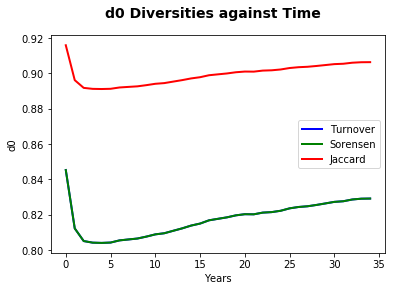

In [22]:
x = [i for i in range(years)]

def plot_d0_pairwise_diversities(x, y1, y2, y3, col1, col2, col3, ylab, xlab='Years'):
    div_typ="d0_pairwise"
    fig = plt.figure()
    fig.suptitle('%s Diversities against Time' % ylab, fontsize=14, fontweight='bold')
    
    ax = fig.add_subplot(111)
    plt.plot(x, y1, color=col1, linewidth=2.0, label='Turnover')
    plt.plot(x, y2, color=col2, linewidth=2.0, label='Sorensen')
    plt.plot(x, y3, color=col3, linewidth=2.0, label='Jaccard')
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    plt.legend()
    fig.savefig('results/%s/%s_%s.jpg' % (graph_typ, div_typ, ylab))
    plt.show

t = np.mean(d0_beta_turnover, axis=0)
s = np.mean(d0_beta_sorensen, axis=0)
j = np.mean(d0_beta_jaccard, axis=0)
plot_d0_pairwise_diversities(x, t, s, j, 'b', 'g', 'r', 'd0')

## For D1

In [30]:
d1_beta_turnover = []
d1_beta_sorensen = []
d1_beta_jaccard = []

start = time.time()
for comb in plot_comb:
    # separate the pairings
    p1 = comb[0]
    p2 = comb[1]
    d1_gamma_diversity = []
    d1_alpha_diversity = []
    for y in range(years):
        # create the plot_species_matrix to calculate diversities
        #print(p1)
        p1_spec = plot_year_species[p1][y]
        p2_spec = plot_year_species[p2][y]
        plot_species_matrix = np.vstack((p1_spec, p2_spec)).transpose()
        
        # calculate gamma diversity
        sum_across_plots = np.sum(plot_species_matrix, axis=1) # gets the sum of each species across plots
        total_abundance = np.sum(sum_across_plots)
        p = np.divide(np.take(sum_across_plots, np.nonzero(sum_across_plots)), total_abundance)
        log_p = np.log(p)
        p_log_p = np.multiply(p, log_p)
        d1_gamma = math.exp(-np.sum(p_log_p))
        d1_gamma_diversity.append(d1_gamma)
        
        # calculate alpha_diversity
        d1_alpha = np.zeros(2)
        total_p1 = np.sum(p1_spec)
        total_p2 = np.sum(p2_spec)
        
        prob1 = np.divide(np.take(p1_spec, np.nonzero(p1_spec)), total_p1)
        log_p1 = np.log(prob1)
        p1_log_p1 = np.multiply(prob1, log_p1)
        d1_alpha_p1 = math.exp(-np.sum(p1_log_p1))
        
        prob2 = np.divide(np.take(p2_spec, np.nonzero(p2_spec)), total_p2)
        log_p2 = np.log(prob2)
        p2_log_p2 = np.multiply(prob2, log_p2)
        d1_alpha_p2 = math.exp(-np.sum(p2_log_p2))
        
        d1_alpha_avg = (d1_alpha_p2 + d1_alpha_p1) / 2
        d1_alpha_diversity.append(d1_alpha_avg)
        
    # Calculate beta diversities
    d1_beta_diversity = np.divide(d1_gamma_diversity, d1_alpha_diversity)
    d1_beta_turnover.append(calculate_turnover(d1_beta_diversity))
    d1_beta_sorensen.append(calculate_sorensen(d1_beta_diversity, 1))
    d1_beta_jaccard.append(calculate_jaccard(d1_beta_diversity, 1))
end = time.time()
print("Time taken for d1: %.2f seconds" % (end-start))

Time taken for d1: 8.37 seconds


## Plotting Pair-wise Beta Diversities for D1

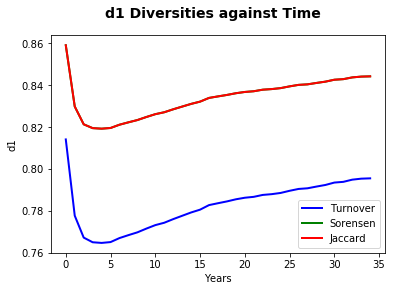

In [31]:
x = [i for i in range(years)]

def plot_d1_pairwise_diversities(x, y1, y2, y3, col1, col2, col3, ylab, xlab='Years'):
    div_typ="d1_pairwise"
    fig = plt.figure()
    fig.suptitle('%s Diversities against Time' % ylab, fontsize=14, fontweight='bold')
    
    ax = fig.add_subplot(111)
    plt.plot(x, y1, color=col1, linewidth=2.0, label='Turnover')
    plt.plot(x, y2, color=col2, linewidth=2.0, label='Sorensen')
    plt.plot(x, y3, color=col3, linewidth=2.0, label='Jaccard')
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    plt.legend()
    fig.savefig('results/%s/%s_%s.jpg' % (graph_typ, div_typ, ylab))
    plt.show

t = np.mean(d1_beta_turnover, axis=0)
s = np.mean(d1_beta_sorensen, axis=0)
j = np.mean(d1_beta_jaccard, axis=0)
plot_d1_pairwise_diversities(x, t, s, j, 'b', 'g', 'r', 'd1')

## For d2

In [51]:
d2_beta_turnover = []
d2_beta_sorensen = []
d2_beta_jaccard = []

start = time.time()

for comb in plot_comb:
    # separate the pairings
    p1 = comb[0]
    p2 = comb[1]
    d2_gamma_diversity = []
    d2_alpha_diversity = []
    for y in range(years):
        # create the plot_species_matrix to calculate diversities
        #print(p1)
        p1_spec = plot_year_species[p1][y]
        p2_spec = plot_year_species[p2][y]
        plot_species_matrix = np.vstack((p1_spec, p2_spec)).transpose()
        
        # calculate gamma diversity
        sum_across_plots = np.sum(plot_species_matrix, axis=1) # gets the sum of each species across plots
        total_abundance = np.sum(sum_across_plots)
        p = np.divide(np.take(sum_across_plots, np.nonzero(sum_across_plots)), total_abundance)
        p = np.power(p, 2)
        d2_gamma = np.divide(1, np.sum(p))
        d2_gamma_diversity.append(d2_gamma)
    
        # calculate alpha_diversity
        d2_alpha = np.zeros(2)
        total_p1 = np.sum(p1_spec)
        total_p2 = np.sum(p2_spec)
        
        prob1 = np.divide(np.take(p1_spec, np.nonzero(p1_spec)), total_p1)
        prob1 = np.power(prob1, 2)
        d2_alpha_p1 = np.divide(1, np.sum(prob1))
        
        prob2 = np.divide(np.take(p2_spec, np.nonzero(p2_spec)), total_p2)
        prob2 = np.power(prob2, 2)
        d2_alpha_p2 = np.divide(1, np.sum(prob1))
        
        d2_alpha_avg = (d2_alpha_p2 + d2_alpha_p1) / 2
        d2_alpha_diversity.append(d2_alpha_avg)
        
    # Calculate beta diversities
    d2_beta_diversity = np.divide(d2_gamma_diversity, d2_alpha_diversity)
    d2_beta_turnover.append(calculate_turnover(d2_beta_diversity))
    d2_beta_sorensen.append(calculate_sorensen(d2_beta_diversity, 2))
    d2_beta_jaccard.append(calculate_jaccard(d2_beta_diversity, 2))
end = time.time()
print("Time taken for d2: %.2f seconds" % (end-start))

[ 1.85175879  1.79112682  1.76700796  1.75189514  1.73783808  1.73565995
  1.75366259  1.7838098   1.78859055  1.74841652  1.76379491  1.72988499
  1.77571256  1.80113393  1.83034792  1.85576284  1.85686631  1.87199942
  1.85350107  1.83518201  1.83388681  1.8002255   1.81818634  1.83976608
  1.84514635  1.86100332  1.87204181  1.84505607  1.85424811  1.87011651
  1.85640763  1.82876296  1.80677494  1.8058264   1.82322524]
Time taken for d2: 7.37 seconds


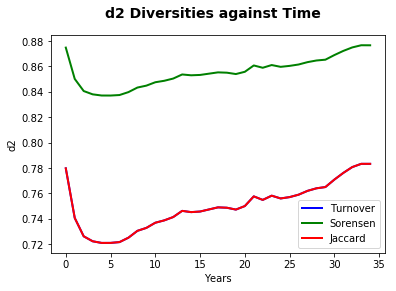

In [54]:
x = [i for i in range(years)]

def plot_d2_pairwise_diversities(x, y1, y2, y3, col1, col2, col3, ylab, xlab='Years'):
    div_typ="d2_pairwise"
    fig = plt.figure()
    fig.suptitle('%s Diversities against Time' % ylab, fontsize=14, fontweight='bold')
    
    ax = fig.add_subplot(111)
    plt.plot(x, y1, color=col1, linewidth=2.0, label='Turnover')
    plt.plot(x, y2, color=col2, linewidth=2.0, label='Sorensen')
    plt.plot(x, y3, color=col3, linewidth=2.0, label='Jaccard')
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    plt.legend()
    fig.savefig('results/%s/%s_%s.jpg' % (graph_typ, div_typ, ylab))
    plt.show

t = np.mean(d2_beta_turnover, axis=0)
s = np.mean(d2_beta_sorensen, axis=0)
j = np.mean(d2_beta_jaccard, axis=0)
plot_d2_pairwise_diversities(x, t, s, j, 'b', 'g', 'r', 'd2')

In [ ]:
from tkinter import *

top = Tk()
L1 = Label(top, text = "User Name")
L1.pack( side = LEFT)
E1 = Entry(top, bd = 5)
E1.pack(side = RIGHT)

print(E1)
top.mainloop()

.4361628976


## Saving to File

In [27]:
def write_to_file(data, filename):
    with file(filename, 'w') as outfile:
        # I'm writing a header here just for the sake of readability
        # Any line starting with "#" will be ignored by numpy.loadtxt
        outfile.write('# Array shape: {0}\n'.format(data.shape))

        # Iterating through a ndimensional array produces slices along
        # the last axis. This is equivalent to data[i,:,:] in this case
        for data_slice in data:

            # The formatting string indicates that I'm writing out
            # the values in left-justified columns 7 characters in width
            # with 2 decimal places.  
            np.savetxt(outfile, data_slice, fmt='%-7.2f')

            # Writing out a break to indicate different slices...
            outfile.write('# New slice\n')
            
write_to_file(plot_year_species, "plot_year_species.txt")

NameError: name 'file' is not defined